**CHAPTER 5<BR>
IMPLEMENTATION**

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from scipy.stats import stats, boxcox
from scipy.stats.mstats import winsorize
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score
from sklearn.metrics import confusion_matrix, r2_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [2]:
df = pd.read_csv('clinvar_conflicting.csv', low_memory=False)

In [3]:
df.head()

,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNDISDB,CLNDISDBINCL,CLNDN,...,SIFT,PolyPhen,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62
0,1,1168180,G,C,0.0771,0.10020,0.1066,MedGen:CN169374,NaN,not_specified,...,tolerated,benign,NaN,NaN,NaN,NaN,NaN,1.053,-0.208682,2.0
1,1,1470752,G,A,0.0000,0.00000,0.0000,"MedGen:C1843891,OMIM:607454,Orphanet:ORPHA9877...",NaN,Spinocerebellar_ataxia_21|not_provided,...,deleterious_low_confidence,benign,NaN,NaN,NaN,NaN,NaN,31.000,6.517838,-3.0
2,1,1737942,A,G,0.0000,0.00001,0.0000,"Human_Phenotype_Ontology:HP:0000486,MedGen:C00...",NaN,Strabismus|Nystagmus|Hypothyroidism|Intellectu...,...,deleterious,probably_damaging,NaN,NaN,NaN,NaN,NaN,28.100,6.061752,-1.0
3,1,2160305,G,A,0.0000,0.00000,0.0000,"MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002...",NaN,Shprintzen-Goldberg_syndrome|not_provided,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.500,3.114491,NaN
4,1,2160305,G,T,0.0000,0.00000,0.0000,"MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002",NaN,Shprintzen-Goldberg_syndrome,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.700,4.766224,-3.0


In [4]:
df['PolyPhen'].factorize()

(array([ 0,  0,  1, ..., -1, -1, -1]),
 Index(['benign', 'probably_damaging', 'possibly_damaging', 'unknown'], dtype='object'))

In [5]:
df['Consequence'].factorize()

(array([0, 0, 0, ..., 5, 5, 0]),
 Index(['missense_variant', 'missense_variant&splice_region_variant',
        'intron_variant', '5_prime_UTR_variant', '3_prime_UTR_variant',
        'synonymous_variant', 'downstream_gene_variant',
        'upstream_gene_variant', 'splice_region_variant&synonymous_variant',
        'splice_region_variant&intron_variant', 'frameshift_variant',
        'inframe_deletion', 'inframe_insertion', 'stop_lost', 'stop_gained',
        'splice_acceptor_variant&coding_sequence_variant&intron_variant',
        'stop_gained&splice_region_variant', 'splice_acceptor_variant',
        'splice_donor_variant', 'start_lost', 'start_lost&5_prime_UTR_variant',
        'splice_donor_variant&coding_sequence_variant&intron_variant',
        'protein_altering_variant', 'stop_gained&frameshift_variant',
        'splice_donor_variant&coding_sequence_variant',
        'splice_region_variant&5_prime_UTR_variant',
        'frameshift_variant&splice_region_variant',
        'start_l

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 46 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CHROM               65188 non-null  object 
 1   POS                 65188 non-null  int64  
 2   REF                 65188 non-null  object 
 3   ALT                 65188 non-null  object 
 4   AF_ESP              65188 non-null  float64
 5   AF_EXAC             65188 non-null  float64
 6   AF_TGP              65188 non-null  float64
 7   CLNDISDB            65188 non-null  object 
 8   CLNDISDBINCL        167 non-null    object 
 9   CLNDN               65188 non-null  object 
 10  CLNDNINCL           167 non-null    object 
 11  CLNHGVS             65188 non-null  object 
 12  CLNSIGINCL          167 non-null    object 
 13  CLNVC               65188 non-null  object 
 14  CLNVI               27659 non-null  object 
 15  MC                  64342 non-null  object 
 16  ORIG

In [7]:
df.shape

(65188, 46)

# Data Cleaning

## Null Values

In [8]:
# create a new dataframe with data type, nulls, & unique values
var_df = pd.DataFrame(columns=['variable_name', 'data_type',\
          'missing_percentage', 'flag','unique_values_count'])

missing_percentages = df.isnull().mean() * 100

# create variables and flag as numeric or categorial
for col in df.columns:
    data_type = df[col].dtype
    missing_percentage = missing_percentages[col]
    unique_values_count = df[col].nunique()
    if data_type == 'int64' or data_type == 'float64':
        flag = 'numeric'
    else:
        flag = 'categorical'
    # concat values obtained into a new dataframe called 'var_df'
    var_df = pd.concat([var_df, pd.DataFrame({'variable_name': [col], \
    'data_type': [data_type], 'missing_percentage': [missing_percentage],\
    'flag': [flag], 'unique_values_count': [unique_values_count]})])

# sort variables by missing percentage value
var_df_sorted = var_df.sort_values(by='missing_percentage')
var_df_sorted.reset_index(drop=True, inplace=True)
var_df_sorted

,variable_name,data_type,missing_percentage,flag,unique_values_count
0,CHROM,object,0.000000,categorical,24
1,Consequence,object,0.000000,categorical,48
2,ORIGIN,int64,0.000000,numeric,31
3,IMPACT,object,0.000000,categorical,4
4,CLNVC,object,0.000000,categorical,7
5,CLNHGVS,object,0.000000,categorical,65188
6,CLASS,int64,0.000000,numeric,2
7,CLNDN,object,0.000000,categorical,9260
8,AF_TGP,float64,0.000000,numeric,2087
9,AF_EXAC,float64,0.000000,numeric,6667


The presented chart highlights columns exhibiting an exceedingly high percentage of missing
values, with nine columns surpassing a 99.5% missing threshold. These columns contain
minimal non-null values, amounting to less than 0.5% of the data. To maintain the integrity and
focus of the project, it is prudent to exclude columns with over 99% missing values, resulting in
the removal of the nine aforementioned columns from the dataset.

In [9]:
# Set the threshold for missing values percentage and drop if necessary
threshold = 99
columns_to_drop = missing_percentages[missing_percentages > threshold].index.tolist()
df = df.drop(columns=columns_to_drop)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             65188 non-null  object 
 1   POS               65188 non-null  int64  
 2   REF               65188 non-null  object 
 3   ALT               65188 non-null  object 
 4   AF_ESP            65188 non-null  float64
 5   AF_EXAC           65188 non-null  float64
 6   AF_TGP            65188 non-null  float64
 7   CLNDISDB          65188 non-null  object 
 8   CLNDN             65188 non-null  object 
 9   CLNHGVS           65188 non-null  object 
 10  CLNVC             65188 non-null  object 
 11  CLNVI             27659 non-null  object 
 12  MC                64342 non-null  object 
 13  ORIGIN            65188 non-null  int64  
 14  CLASS             65188 non-null  int64  
 15  Allele            65188 non-null  object 
 16  Consequence       65188 non-null  object

Having removed the initial set of columns, we are now poised to delve into the exploration of
variable relationships, thereby unraveling potential inconsistencies and errors embedded within
the data. To gain valuable insights, a comprehensive heat matrix analysis will be employed,
enabling the identification of correlations among numeric variables. This initial step promises to
shed light on significant patterns and dependencies, paving the way for informed decisionmaking
and further data analysis.

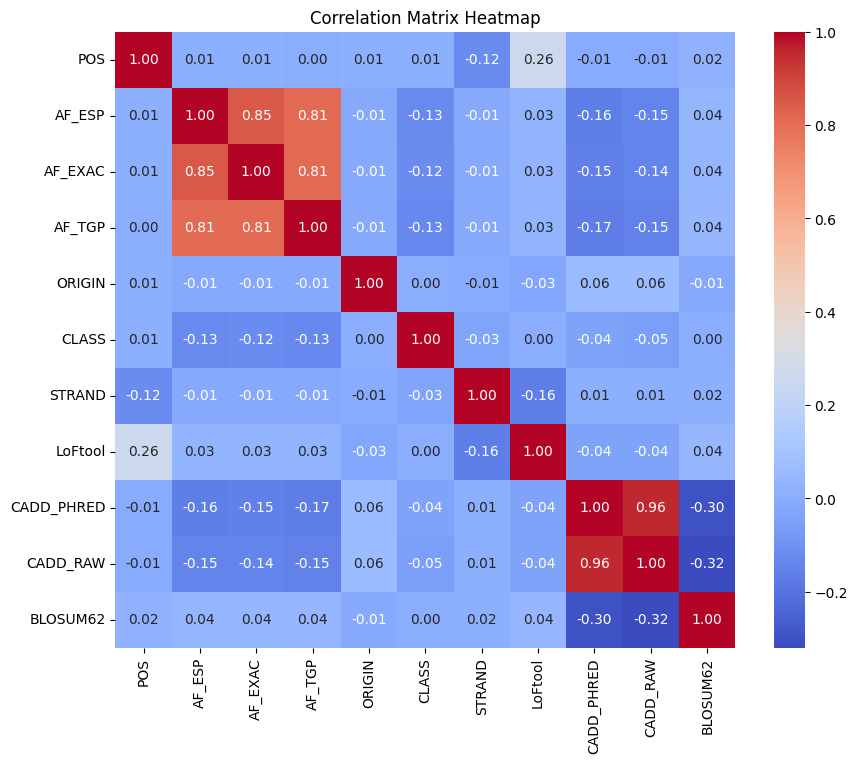

In [10]:
# filter numerical columns and create correlation heat matrix map
numerical_columns = df.select_dtypes(include=['int64', 'float64'])
corr_matrix = numerical_columns.corr() # calculate correlations
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

##Drop Unnecessary Variables
Within the context of this project and experiment, there exists a selection of columns within the
main 'df' dataframe that can be readily discarded due to their lack of relevance or redundancy:
1. BAM_EDIT: Pertaining to Binary Map Alignment, it does not offer pertinent information for
this analysis.
2. INTRON: With a significantly low number of non-null values and containing dates, it does
not align with the objectives of this study.
3. EXON: Comprising date-related information, it is not applicable since this project does not
involve time series analysis.
4. CLNDISDB: Providing MedGen database identifiers, it does not contribute to the current
investigation.
5. CLNHGVS: Serving as a database identifier, it does not bear relevance for the purposes of
this study.
6. MC: A redundant column replicating the information found in the 'Consequence' column
alongside an additional database identifier.
7. CLNVI: Representing a lab location identifier, it holds no significance in the present project.
8. SYMBOL: Constituting another identifier, it duplicates existing information and can be
omitted.
9. Feature: The information it encompasses is already included in the 'Consequence' column.
10. Feature_type: The information it entails is already included in the 'Consequence' column.
11. BIOTYPE: The information it encompasses is already included in the 'Consequence' column.
12. CADD_RAW: While related to CADD_PHRED, only CADD_PHRED is essential for this genetic
mutation analysis due to its usage of a more manageable scale.
13. Allele: As it contains the same values as the 'ALT' column, it can be regarded as a duplicate
entry and removed accordingly.
By eliminating these redundant or irrelevant columns, the data will be streamlined and more
focused, enhancing the accuracy and efficiency of subsequent analyses.

In [11]:
df.drop(['BAM_EDIT', 'EXON', 'CLNDISDB', 'CLNHGVS',
'MC', 'CLNVI', 'SYMBOL', 'Feature', 'Feature_type',
'BIOTYPE', 'INTRON', 'CADD_RAW', 'Allele'], axis=1, inplace=True)
df.columns

Index(['CHROM', 'POS', 'REF', 'ALT', 'AF_ESP', 'AF_EXAC', 'AF_TGP', 'CLNDN',
       'CLNVC', 'ORIGIN', 'CLASS', 'Consequence', 'IMPACT', 'cDNA_position',
       'CDS_position', 'Protein_position', 'Amino_acids', 'Codons', 'STRAND',
       'SIFT', 'PolyPhen', 'LoFtool', 'CADD_PHRED', 'BLOSUM62'],
      dtype='object')

In [12]:
# Create an empty DataFrame to store the columns with missing values
still_missing = pd.DataFrame()

# Iterate over the columns of the DataFrame and isolate missing columns
for column in df.columns:
    if df[column].isnull().any():
        still_missing[column] = df[column]

print("Columns with missing values:")
still_missing.info()

Columns with missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cDNA_position     56304 non-null  object 
 1   CDS_position      55233 non-null  object 
 2   Protein_position  55233 non-null  object 
 3   Amino_acids       55184 non-null  object 
 4   Codons            55184 non-null  object 
 5   STRAND            65174 non-null  float64
 6   SIFT              24836 non-null  object 
 7   PolyPhen          24796 non-null  object 
 8   LoFtool           60975 non-null  float64
 9   CADD_PHRED        64096 non-null  float64
 10  BLOSUM62          25593 non-null  float64
dtypes: float64(4), object(7)
memory usage: 5.5+ MB


##Forward Fill and Interpolation of Remaining Nulls
In order to handle missing values in the dataset, a forward fill (ffill) approach was employed for
both the 'BLOSUM62' column and object columns. This method was selected to propagate the
last observed non-null value forward, maintaining the temporal coherence of the data.
BLOSUM62 was also transformed via forward fill because of it's low count categorical nature.
For numerical columns, interpolation was utilized to estimate missing values based on existing
data points, ensuring a smooth transition and preserving the underlying trends and patterns in
the numerical data.

In [13]:
for column in still_missing.columns:
  if column == 'BLOSUM62':
    # Fill missing values in the 'BLOSUM62' column with forward fill (ffill)
    still_missing[column] = still_missing[column].fillna(method='ffill')
  elif still_missing[column].dtype == 'object':
    # Fill missing values in object columns with forward fill (ffill)
    still_missing[column] = still_missing[column].fillna(method='ffill')
  elif still_missing[column].dtype == 'float64':
    # Interpolate missing values in float64 columns
    still_missing[column] = still_missing[column].interpolate()

# Fill missing values in 'LoFtool' column with 0
still_missing['LoFtool'] = still_missing['LoFtool'].fillna(0)

# update main dataframe
df.update(still_missing)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             65188 non-null  object 
 1   POS               65188 non-null  int64  
 2   REF               65188 non-null  object 
 3   ALT               65188 non-null  object 
 4   AF_ESP            65188 non-null  float64
 5   AF_EXAC           65188 non-null  float64
 6   AF_TGP            65188 non-null  float64
 7   CLNDN             65188 non-null  object 
 8   CLNVC             65188 non-null  object 
 9   ORIGIN            65188 non-null  int64  
 10  CLASS             65188 non-null  int64  
 11  Consequence       65188 non-null  object 
 12  IMPACT            65188 non-null  object 
 13  cDNA_position     65188 non-null  object 
 14  CDS_position      65188 non-null  object 
 15  Protein_position  65188 non-null  object 
 16  Amino_acids       65188 non-null  object

# Data Exploratory Analysis

## Outliers and Transformations

In [14]:
df.nunique()

CHROM                  24
POS                 63115
REF                   866
ALT                   458
AF_ESP               2842
AF_EXAC              6667
AF_TGP               2087
CLNDN                9260
CLNVC                   7
ORIGIN                 31
CLASS                   2
Consequence            48
IMPACT                  4
cDNA_position       13970
CDS_position        13663
Protein_position     7339
Amino_acids          1262
Codons               2220
STRAND                  7
SIFT                    4
PolyPhen                4
LoFtool              5199
CADD_PHRED          10111
BLOSUM62                6
dtype: int64

In [15]:
df['REF'].unique()

array(['G', 'A', 'T', 'C', 'CAG', 'GCCCTCCTCTGAGTCTTCCTCCCCTTCCCGTA',
       'AG', 'TTCCTCC', 'TTCC', 'CTT', 'CAGACCGCAGGCTGGAGACCA',
       'AACACCCGCAAGAAGCCGGTAGTCT', 'CCAGGCTGGGGAAG', 'TAGAG', 'TG', 'TC',
       'GGAAGAA', 'ATGAGG', 'TACTA', 'AC', 'CG', 'CT', 'TA',
       'AGCCGCCGCCAGCCGCAGCCATGGGCCGGGCCCGGCCGGGCCAACGCGGGCCGCCCAGCCCCGGCCCCGCCGCGCAGCCTCCCGCGCCACCGC',
       'CCCCGCCGCCGCCAGCAGCCTGGGCAA', 'GA', 'CCA', 'TACG',
       'GCCTGCACAAGGA', 'CTAAAGT', 'TGGAGGGAG', 'TT', 'CCT',
       'AGACCGAAAGAAATTATCCAGGACTTGCTGGCCCATGCGGGGCTTTTTCC', 'TGTTG',
       'CAAG', 'GTAGTGCC', 'AT', 'AGGTCACGGACG', 'GC', 'CAA',
       'TAGCCCAGGCC', 'TCCTATTTCCCCTA', 'CCCAA', 'CAGA',
       'GAACCCTGCAAAAAGTGACACTATC', 'ACTG', 'TTTG', 'TTTAA', 'AAAG',
       'GAAGT', 'ATGAC', 'GTTGCAATGGGAGC', 'CAGTT', 'TTTTG', 'TAGA',
       'GAGA', 'AGAG', 'AGAGGAG', 'CAGG', 'TGGA', 'CAGAG', 'CAGAGAGAGAG',
       'GTGCCCCAGGGCCAAC', 'GGT', 'AAC', 'AGCGCACCGTCTTT', 'TAGAC', 'TGA',
       'GAAAAA', 'CCATCAT', 'C

Regarding the 'REF' and 'ALT' columns denoting the original allele and altered allele (mutation),
it is customary for these values to consist of a single letter representing one of the four
nucleotide bases: G, C, A, T. However, upon examination using the unique counts function, it
becomes evident that these columns contain an excessive number of unique values. This can be
attributed to anomalous entries where multiple letters are present instead of a single letter.
These anomalies represent a very small portion of the data. Consequently, rows containing such
multi-letter values will be excluded from further analysis to ensure data integrity and adherence
to the expected format.

In [16]:
# Define the allowed values
allowed_values = ['A', 'T', 'C', 'G']

# Iterate over each column and isolate allowed values
for column in ['REF', 'ALT']:
    df = df[df[column].isin(allowed_values)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61281 entries, 0 to 65187
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             61281 non-null  object 
 1   POS               61281 non-null  int64  
 2   REF               61281 non-null  object 
 3   ALT               61281 non-null  object 
 4   AF_ESP            61281 non-null  float64
 5   AF_EXAC           61281 non-null  float64
 6   AF_TGP            61281 non-null  float64
 7   CLNDN             61281 non-null  object 
 8   CLNVC             61281 non-null  object 
 9   ORIGIN            61281 non-null  int64  
 10  CLASS             61281 non-null  int64  
 11  Consequence       61281 non-null  object 
 12  IMPACT            61281 non-null  object 
 13  cDNA_position     61281 non-null  object 
 14  CDS_position      61281 non-null  object 
 15  Protein_position  61281 non-null  object 
 16  Amino_acids       61281 non-null  object 
 17

In [17]:
df.nunique()

CHROM                  24
POS                 59822
REF                     4
ALT                     4
AF_ESP               2827
AF_EXAC              6568
AF_TGP               2064
CLNDN                8726
CLNVC                   1
ORIGIN                 30
CLASS                   2
Consequence            23
IMPACT                  4
cDNA_position       12010
CDS_position        11801
Protein_position     6381
Amino_acids           305
Codons                766
STRAND                  7
SIFT                    4
PolyPhen                4
LoFtool              4940
CADD_PHRED           9225
BLOSUM62                6
dtype: int64

In [18]:
# Create a copy of df to preserve the cleaned dataframe
# before encoding
df_original = df.copy()
df_factorized = df.copy()

# Iterate over each column in the dataframe
for column in df_factorized.columns:
  # Check if the column's dtype is 'object'
  if df_factorized[column].dtype == 'object':
    df_factorized[column] = pd.factorize(df_factorized[column])[0]

df = df_factorized
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61281 entries, 0 to 65187
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             61281 non-null  int64  
 1   POS               61281 non-null  int64  
 2   REF               61281 non-null  int64  
 3   ALT               61281 non-null  int64  
 4   AF_ESP            61281 non-null  float64
 5   AF_EXAC           61281 non-null  float64
 6   AF_TGP            61281 non-null  float64
 7   CLNDN             61281 non-null  int64  
 8   CLNVC             61281 non-null  int64  
 9   ORIGIN            61281 non-null  int64  
 10  CLASS             61281 non-null  int64  
 11  Consequence       61281 non-null  int64  
 12  IMPACT            61281 non-null  int64  
 13  cDNA_position     61281 non-null  int64  
 14  CDS_position      61281 non-null  int64  
 15  Protein_position  61281 non-null  int64  
 16  Amino_acids       61281 non-null  int64  
 17

Reason for Factorized Encoding:
This type of encoding was used to assign a numerical value to every unique value in the object
columns without introducing any sort of rank or compromising dimensionality. One hot
encoding was not chosen because it significantly increased the dimensionality of the large
dataset, reducing efficiency. Additionally, label encoding was not chosen because it introduces
rank into the unique values of the object columns. Currently, all object columns are considered
nominal and shall be treated as such.

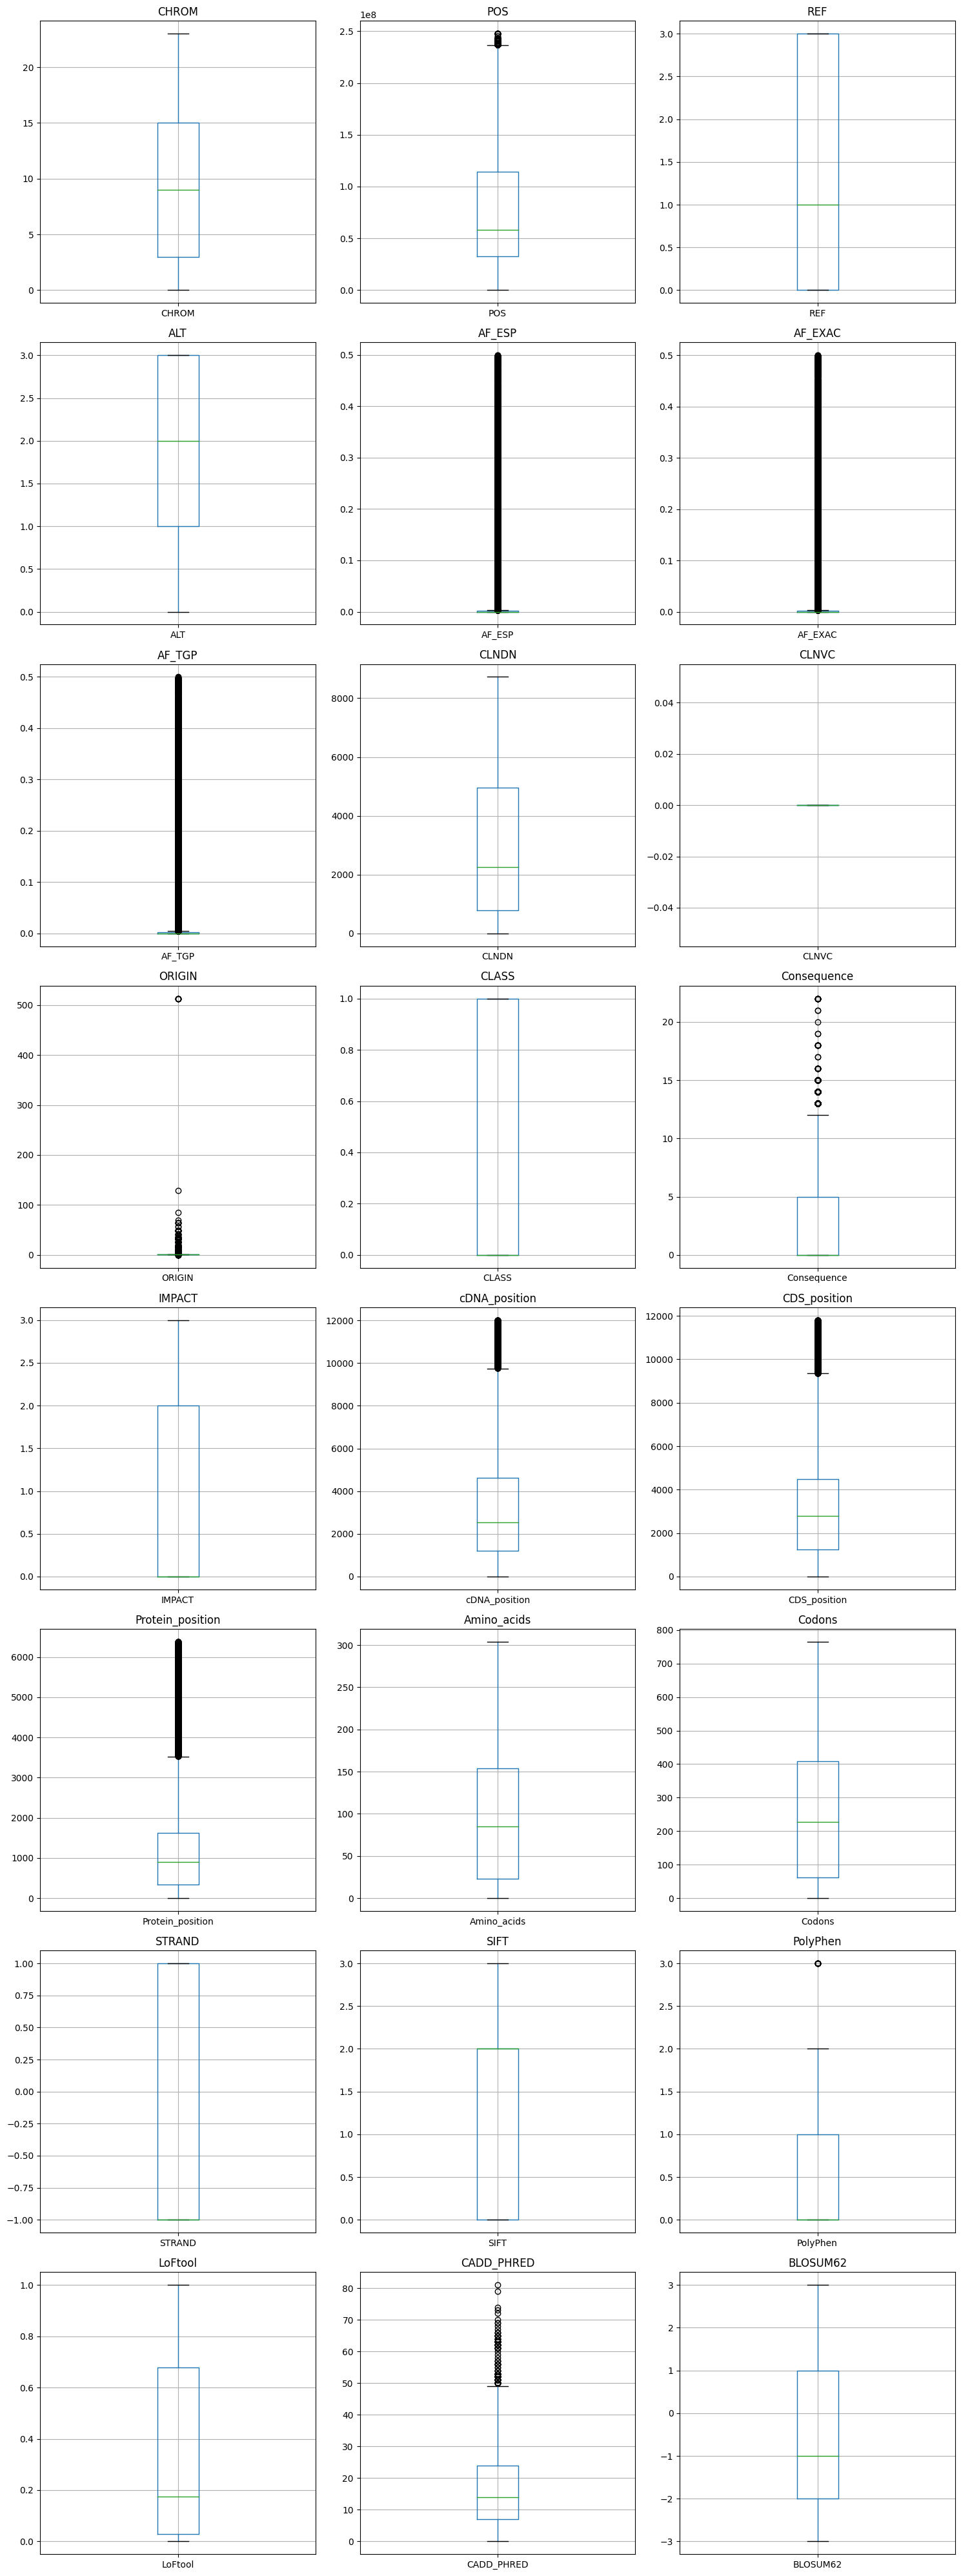

In [19]:
# Calculate the number of rows and columns for subplots
num_columns = 3
num_rows = (len(df.columns) - 1) // num_columns + 1

# Create subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 40))

# Iterate through columns and plot boxplots
for i, column in enumerate(df.columns):
  row = i // num_columns
  col = i % num_columns
  ax = axes[row][col]
  df.boxplot(column=column, ax=ax)
  ax.set_title(column)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

## Allele Frequency Visualization

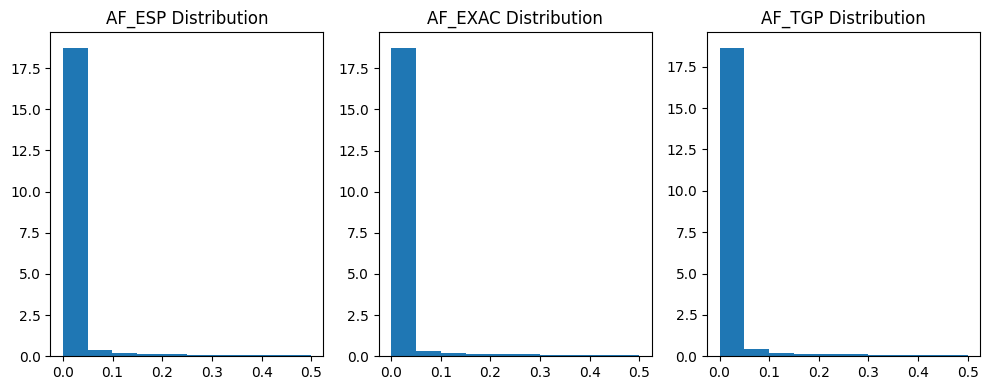

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10, 4))

# Plot histograms for each column
ax1.hist(df['AF_ESP'], bins=10, density=True)
ax1.set_title('AF_ESP Distribution')

ax2.hist(df['AF_EXAC'], bins=10, density=True)
ax2.set_title('AF_EXAC Distribution')

ax3.hist(df['AF_TGP'], bins=10, density=True)
ax3.set_title('AF_TGP Distribution')

plt.tight_layout()
plt.show()

The distributions of allele frequencies displayed above exhibit similar patterns and significant
right-skewness. Additionally, the absence of missing values (0% missing) and high correlation
among all three columns further suggest their similarity.
However, a crucial aspect requires attention. Despite the columns appearing identical and
having no missing values, it is important to acknowledge that in the original database, missing
values are labeled as "0" in these columns. Consequently, when iterating through the column,
Python interprets these "0" values as non-null rather than null.
To gain deeper insights into the actual missing values within the columns labeled as "0," let us
conduct a thorough exploration.

In [21]:
allele_df = df[['AF_ESP', 'AF_EXAC', 'AF_TGP']]
allele_df.info()

# initiate count of three new variables
esp_zeros = 0
exac_zeros = 0
tgp_zeros = 0

# iterate through allele_df and print count of zeroes
for column in allele_df.columns:
  column_values = allele_df[column].values
  zeros_count = len(column_values[column_values == 0])
  if column == 'AF_ESP':
    esp_zeros += zeros_count
  elif column == 'AF_EXAC':
    exac_zeros += zeros_count
  elif column == 'AF_TGP':
    tgp_zeros += zeros_count
print("Count of zeroes (missing values) in AF_ESP column:", esp_zeros)
print("Count of zeroes (missing values) in AF_EXAC column:", exac_zeros)
print("Count of zeroes (missing values) in AF_TGP column:", tgp_zeros)

<class 'pandas.core.frame.DataFrame'>
Index: 61281 entries, 0 to 65187
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   AF_ESP   61281 non-null  float64
 1   AF_EXAC  61281 non-null  float64
 2   AF_TGP   61281 non-null  float64
dtypes: float64(3)
memory usage: 1.9 MB
Count of zeroes (missing values) in AF_ESP column: 32042
Count of zeroes (missing values) in AF_EXAC column: 20858
Count of zeroes (missing values) in AF_TGP column: 34310


In [22]:
esp_missing = round((esp_zeros / len(allele_df)) * 100, 2)
exac_missing = round((exac_zeros / len(allele_df)) * 100, 2)
tgp_missing = round((tgp_zeros / len(allele_df)) * 100, 2)
print("Percentage of actual missing values in AF_ESP column:", esp_missing)
print("Percentage of actual missing values in AF_EXAC column:", exac_missing)
print("Percentage of actual missing values in AF_TGP column:", tgp_missing)

Percentage of actual missing values in AF_ESP column: 52.29
Percentage of actual missing values in AF_EXAC column: 34.04
Percentage of actual missing values in AF_TGP column: 55.99


The subsequent step involves visualizing the distributions after removing the null values, which
will provide further insights into the data.

In [23]:
for column in allele_df.columns:
  allele_df.loc[allele_df[column] == 0, column] = None

allele_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61281 entries, 0 to 65187
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   AF_ESP   29239 non-null  float64
 1   AF_EXAC  40423 non-null  float64
 2   AF_TGP   26971 non-null  float64
dtypes: float64(3)
memory usage: 1.9 MB


The 'allele_df' dataframe above now has the correct count of non-null values in each column.

In [24]:
# Define the methods for filling null values
methods = ['mean', 'median', 'interpolation']

# Calculate skewness and kurtosis for original DataFrame
original_skewness = allele_df.skew()
original_kurtosis = allele_df.kurtosis()

# Create a dictionary to store the results
results = {}

# Iterate over the methods
for method in methods:

  # Fill null values using the respective method
  if method == 'mean':
    filled_df = allele_df.fillna(allele_df.mean())
  elif method == 'median':
    filled_df = allele_df.fillna(allele_df.median())
  elif method == 'interpolation':
    filled_df = allele_df.interpolate()

  # Calculate skewness and kurtosis
  skewness = filled_df.skew()
  kurtosis = filled_df.kurtosis()

  # Store the results in the dictionary
  results[method] = {'skewness': skewness, 'kurtosis': kurtosis}

# Print the results
for method in methods:
  print(f"DataFrame with {method.capitalize()}-Filled Null Values:")
  print("Skewness:\n", results[method]['skewness'])
  print("Kurtosis:\n", results[method]['kurtosis'])
  print()

DataFrame with Mean-Filled Null Values:
Skewness:
 AF_ESP     5.075619
AF_EXAC    5.203414
AF_TGP     4.909067
dtype: float64
Kurtosis:
 AF_ESP     29.240401
AF_EXAC    29.424542
AF_TGP     27.715173
dtype: float64

DataFrame with Median-Filled Null Values:
Skewness:
 AF_ESP     5.339052
AF_EXAC    5.328660
AF_TGP     5.227334
dtype: float64
Kurtosis:
 AF_ESP     30.488536
AF_EXAC    30.064269
AF_TGP     29.190748
dtype: float64

DataFrame with Interpolation-Filled Null Values:
Skewness:
 AF_ESP     4.117839
AF_EXAC    4.631401
AF_TGP     3.797907
dtype: float64
Kurtosis:
 AF_ESP     18.463492
AF_EXAC    22.978133
AF_TGP     15.628036
dtype: float64



The skewness and kurtosis values for the three types of null value filling are presented above. It
has been observed that interpolation yields the least skewness and kurtosis on the data.
Therefore, for the duration of the project, interpolation will be utilized for all three columns.

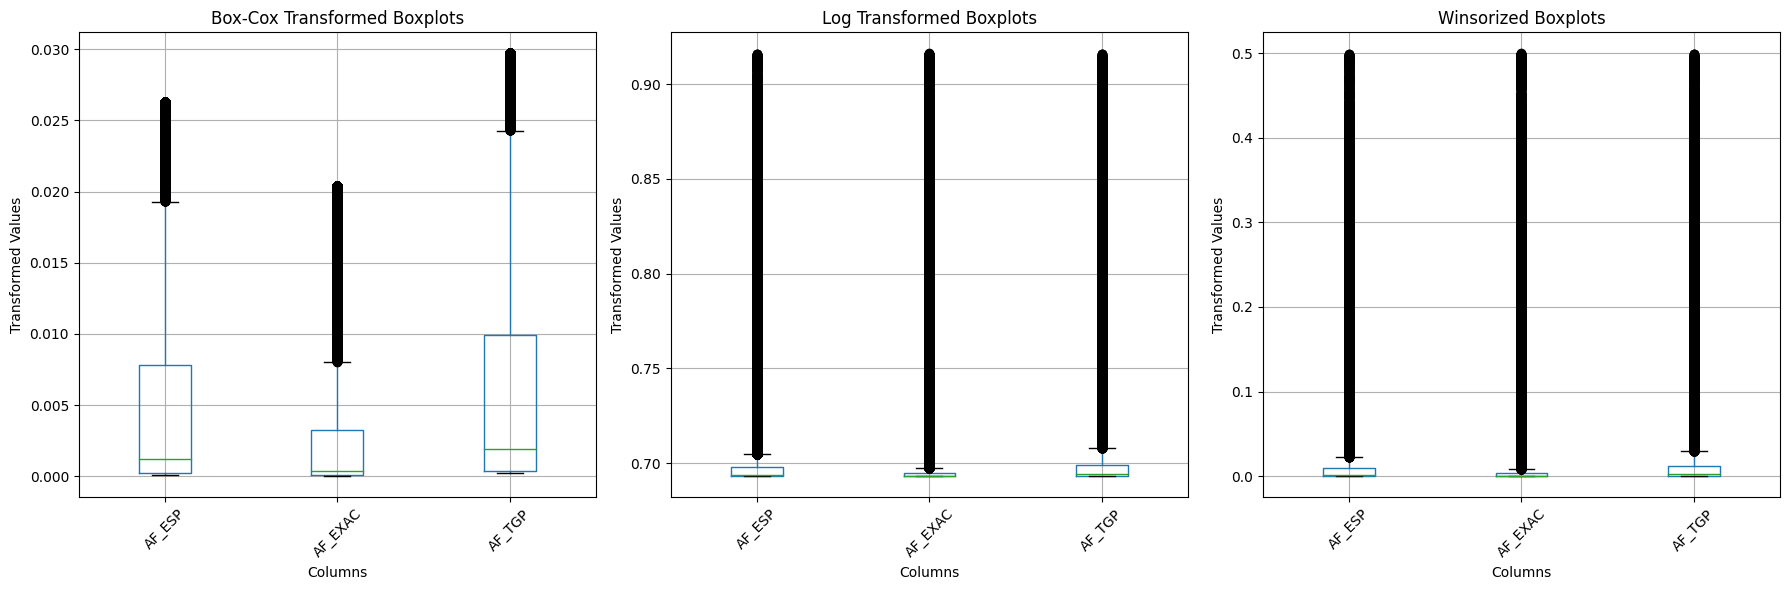

In [25]:
allele_df = allele_df.interpolate()
# Apply Box-Cox transformation to the DataFrame
allele_df_boxcox = allele_df.copy()
for column in allele_df_boxcox.columns:
  transformed_data, _ = boxcox(allele_df_boxcox[column].dropna() + 1)
  allele_df_boxcox[column].loc[~allele_df_boxcox[column].isna()] = transformed_data

log_constant = 1
allele_df_log = np.log1p(allele_df + log_constant)

# Apply winsorization to the DataFrame
allele_df_winsorized = allele_df.copy()
for column in allele_df_winsorized.columns:
  allele_df_winsorized[column] = winsorize(allele_df_winsorized[column].dropna())

# Create boxplots of transformed columns
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Box-Cox transformed boxplots
allele_df_boxcox.boxplot(ax=axes[0])
axes[0].set_title("Box-Cox Transformed Boxplots")
axes[0].set_xticklabels(allele_df_boxcox.columns, rotation=45)
axes[0].set_xlabel("Columns")
axes[0].set_ylabel("Transformed Values")

# Log transformed boxplots
allele_df_log.boxplot(ax=axes[1])
axes[1].set_title("Log Transformed Boxplots")
axes[1].set_xticklabels(allele_df_log.columns, rotation=45)
axes[1].set_xlabel("Columns")
axes[1].set_ylabel("Transformed Values")

# Winsorized boxplots
allele_df_winsorized.boxplot(ax=axes[2])
axes[2].set_title("Winsorized Boxplots")
axes[2].set_xticklabels(allele_df_winsorized.columns, rotation=45)
axes[2].set_xlabel("Columns")
axes[2].set_ylabel("Transformed Values")

# Adjusting the layout
plt.tight_layout()

# Display the plot
plt.show()

Considering the boxplot representations above, it becomes evident that the Box-Coxtransformation yields the most effective transformation for handling outliers in all threecolumns. Therefore, it is appropriate to update our main dataframe accordingly to incorporatethe transformed values.

In [26]:
df.update(allele_df_boxcox)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61281 entries, 0 to 65187
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             61281 non-null  int64  
 1   POS               61281 non-null  int64  
 2   REF               61281 non-null  int64  
 3   ALT               61281 non-null  int64  
 4   AF_ESP            61281 non-null  float64
 5   AF_EXAC           61281 non-null  float64
 6   AF_TGP            61281 non-null  float64
 7   CLNDN             61281 non-null  int64  
 8   CLNVC             61281 non-null  int64  
 9   ORIGIN            61281 non-null  int64  
 10  CLASS             61281 non-null  int64  
 11  Consequence       61281 non-null  int64  
 12  IMPACT            61281 non-null  int64  
 13  cDNA_position     61281 non-null  int64  
 14  CDS_position      61281 non-null  int64  
 15  Protein_position  61281 non-null  int64  
 16  Amino_acids       61281 non-null  int64  
 17

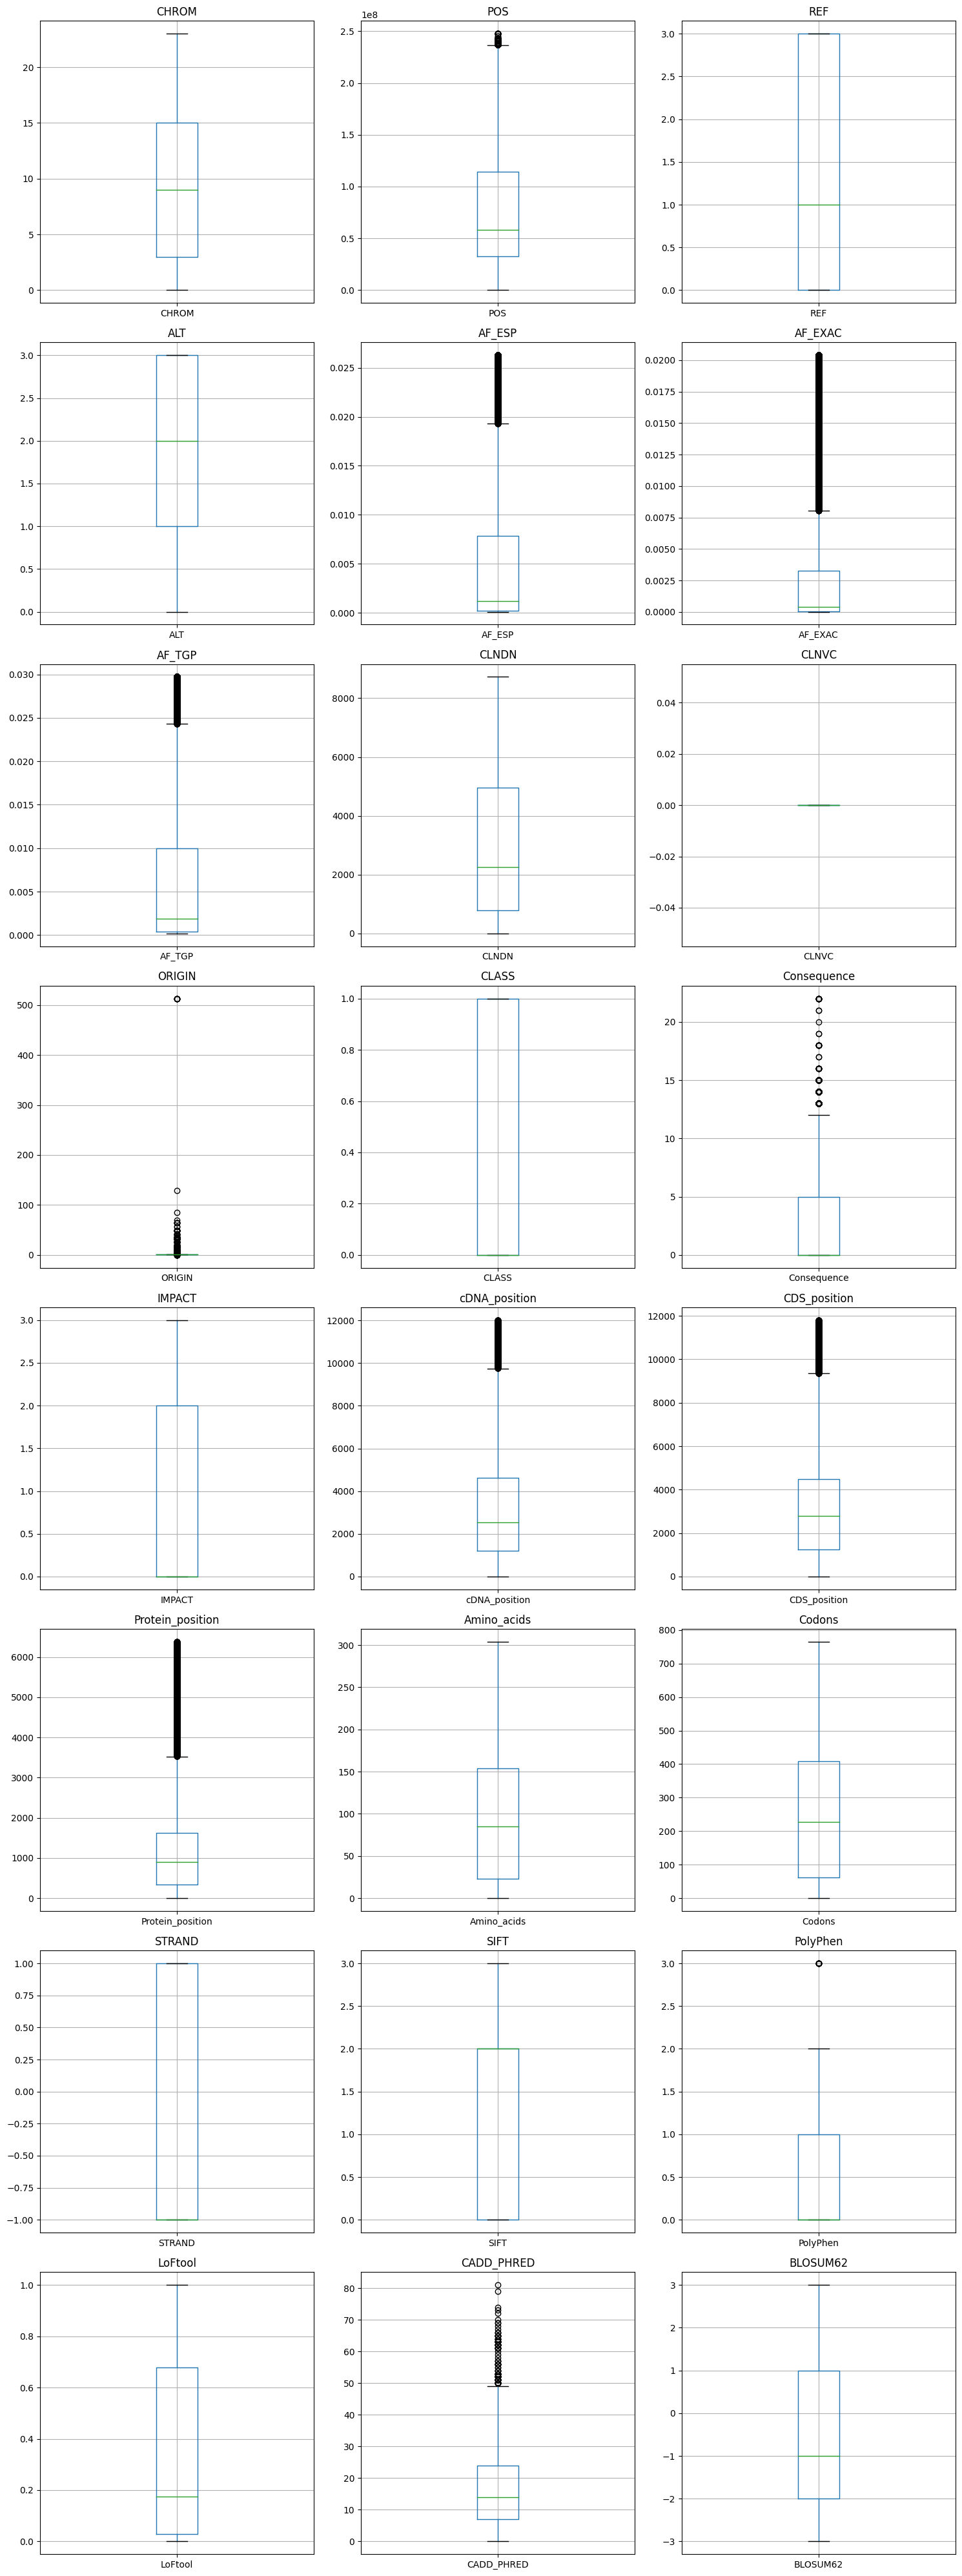

In [27]:
# Calculate the number of rows and columns for subplots
num_columns = 3
num_rows = (len(df.columns) - 1) // num_columns + 1
# Create subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 40))
# Iterate through columns and plot boxplots
for i, column in enumerate(df.columns):
  row = i // num_columns
  col = i % num_columns
  ax = axes[row][col]
  df.boxplot(column=column, ax=ax)
  ax.set_title(column)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [28]:
# Calculate z-scores for each column
z_scores = df.apply(stats.zscore)
# Identify outliers using z-score threshold
z_score_threshold = 3 # Adjust the threshold as needed
# Calculate the number of outliers for each column
num_outliers = (np.abs(z_scores) > z_score_threshold).sum()
# Print the number of outliers for each column
print("Number of Outliers:")
print(num_outliers)

Number of Outliers:
CHROM                  0
POS                    0
REF                    0
ALT                    0
AF_ESP                 0
AF_EXAC                0
AF_TGP                 0
CLNDN                  0
CLNVC                  0
ORIGIN               368
CLASS                  0
Consequence         1034
IMPACT                 0
cDNA_position        299
CDS_position         389
Protein_position    1882
Amino_acids           34
Codons                 0
STRAND                 0
SIFT                   0
PolyPhen              14
LoFtool                0
CADD_PHRED           162
BLOSUM62               0
dtype: int64


<ipython-input-28-08ae71b2dda2>:2: DeprecationWarning: Please use `zscore` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  z_scores = df.apply(stats.zscore)


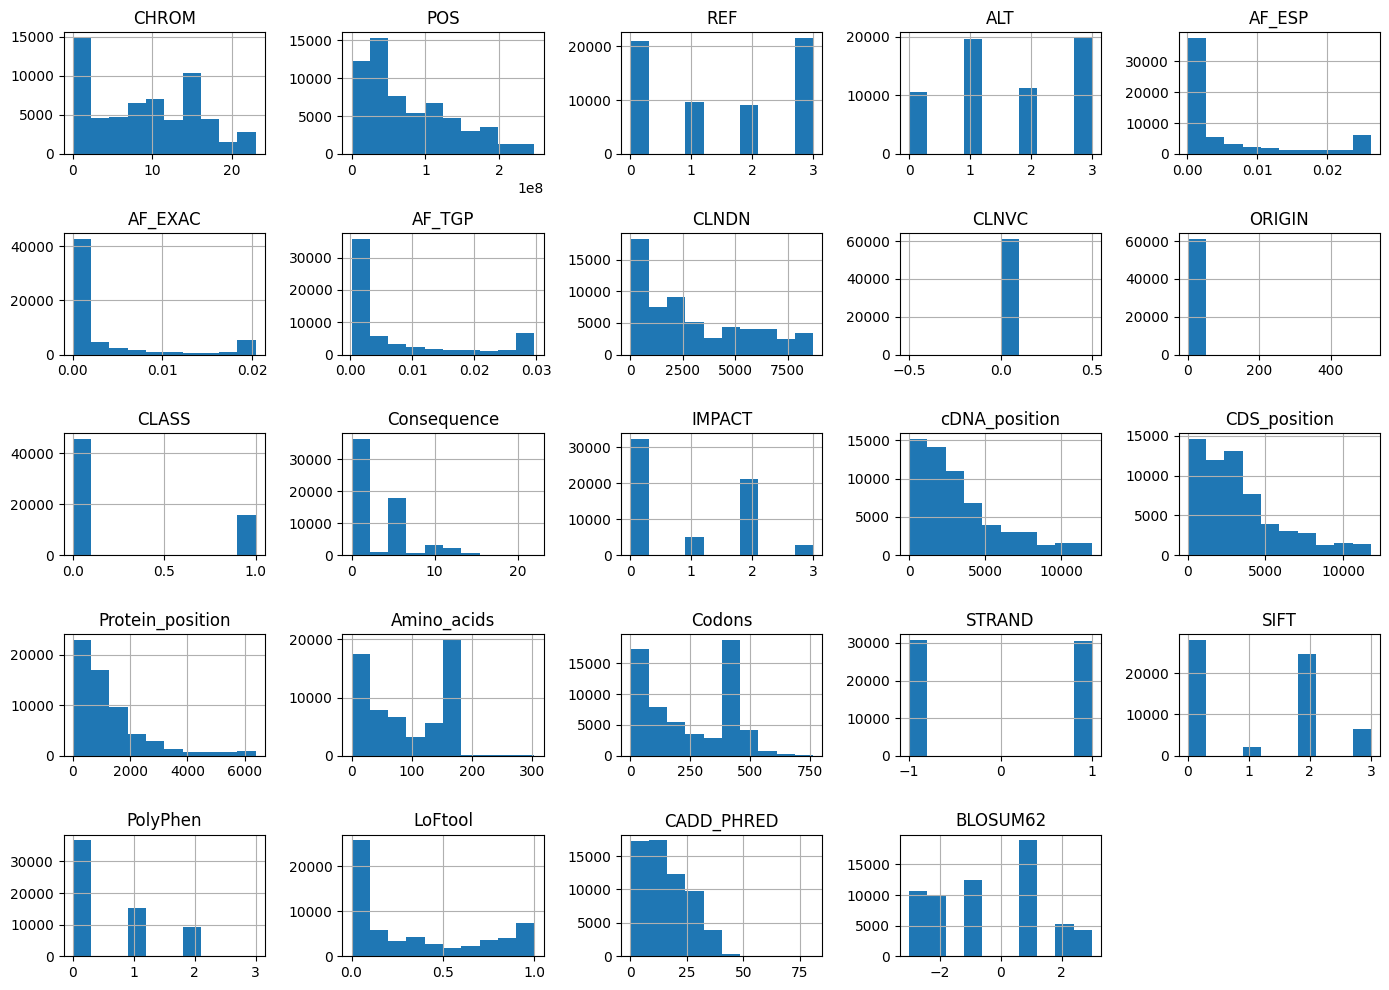

In [29]:
# Plot histograms of all columns with larger size
df.hist(figsize=(14, 10))
plt.tight_layout()
plt.show()

The variable 'CLNVC' contains only one unique value amongst all cells of the cleaned dataframe.
Thus, it must be dropped as a duplicate variable.

In [30]:
df = df.drop('CLNVC', axis=1)
df.columns

Index(['CHROM', 'POS', 'REF', 'ALT', 'AF_ESP', 'AF_EXAC', 'AF_TGP', 'CLNDN',
       'ORIGIN', 'CLASS', 'Consequence', 'IMPACT', 'cDNA_position',
       'CDS_position', 'Protein_position', 'Amino_acids', 'Codons', 'STRAND',
       'SIFT', 'PolyPhen', 'LoFtool', 'CADD_PHRED', 'BLOSUM62'],
      dtype='object')

## Correlation Heat Map

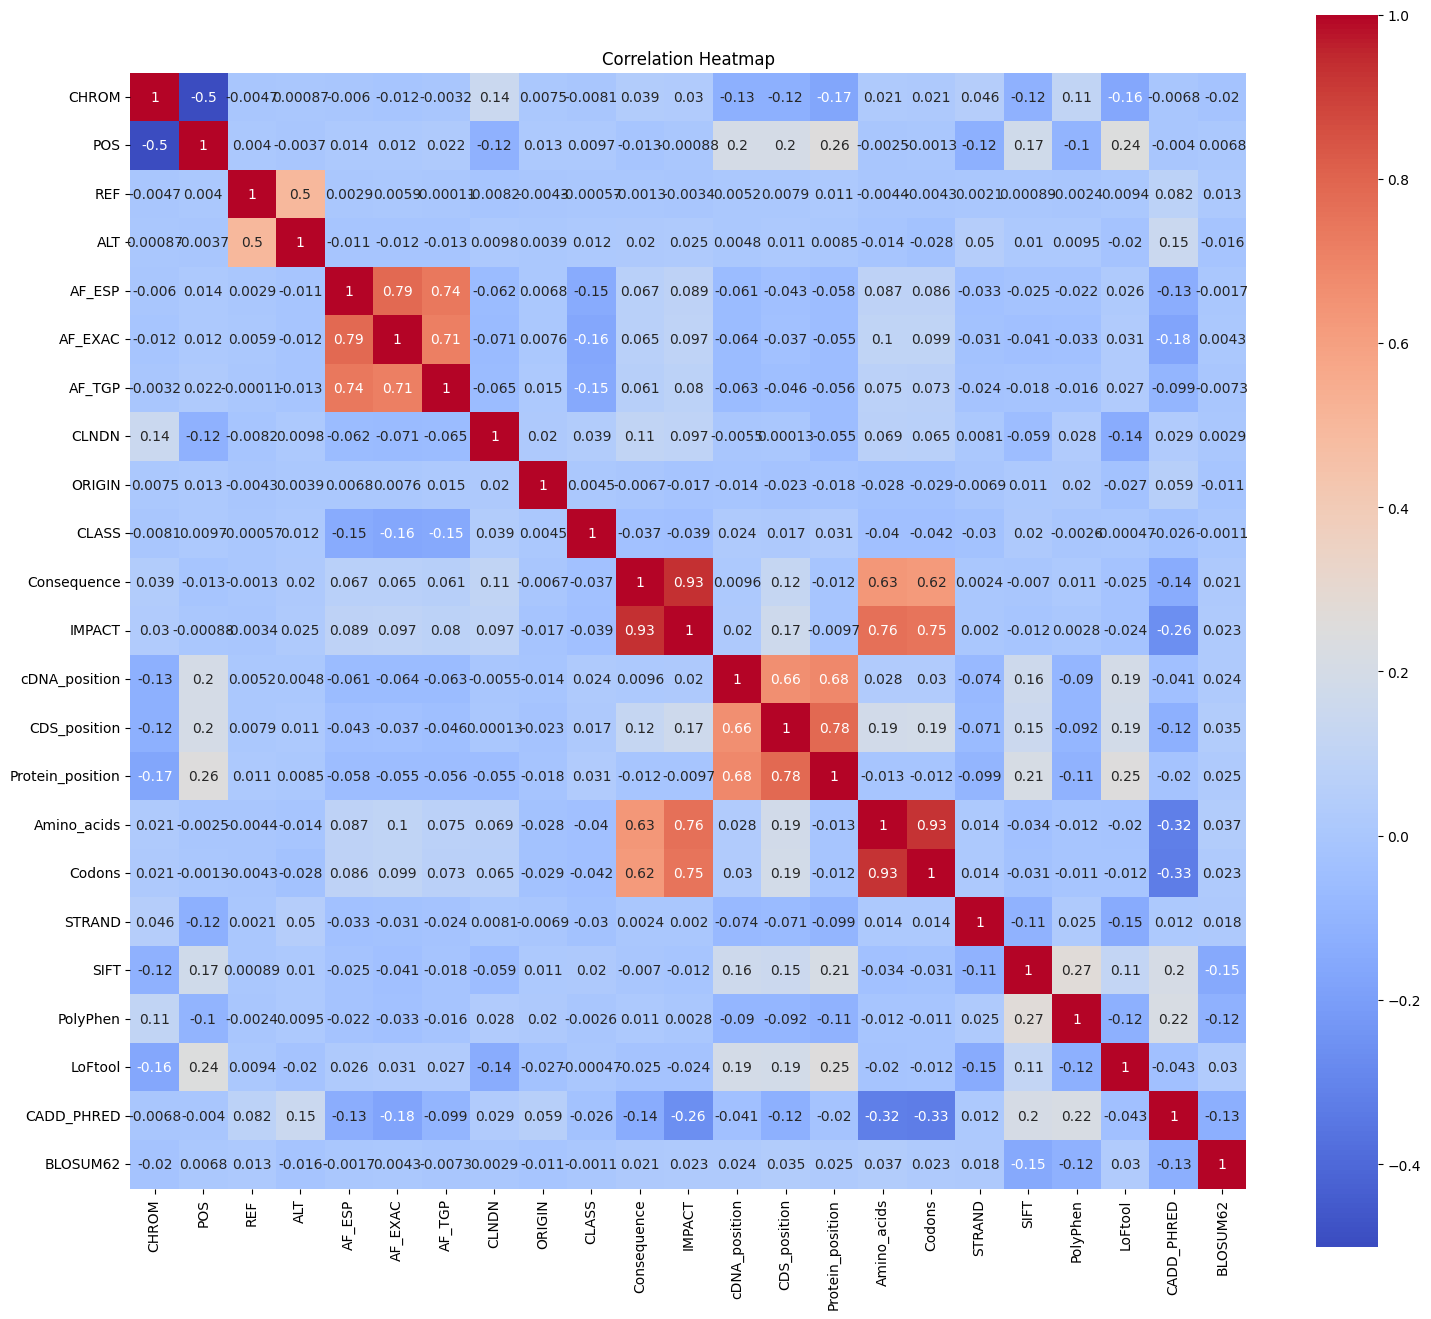

In [31]:
# Create a heatmap
plt.figure(figsize=(18, 16))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
# Set the title
plt.title('Correlation Heatmap')
# Display the heatmap
plt.show()

The correlation heat map above highlights the presence of high correlations among certain variables. This scenario can have both positive and negative implications for the model. When
the target variable exhibits strong correlations with features, it can indicate that these variables
serve as reliable predictors. However, it is important to consider the possibility of collinearity
issues, where high correlations between predictor variables might lead to multicollinearity
concerns.


To address these dynamics, we will delve into feature engineering and feature selection
methodologies, aiming to enhance the project's analytical capabilities. By employing strategic
techniques, we can uncover valuable insights, optimize the predictive power of the selected
features, and mitigate the potential impact of collinearity.

In [32]:
# Get the correlation matrix
corr_matrix = df.corr()
# Create a list to store correlation pairs
correlation_pairs = []
# Iterate through the correlation matrix
for i, column1 in enumerate(corr_matrix.columns):
  for j, column2 in enumerate(corr_matrix.columns):
    if i < j: # Use i < j to avoid duplicate pairs
      correlation = abs(corr_matrix[column1][column2])
      if correlation > 0.15: # Filter correlations above 0.10
        correlation_pairs.append((column1, column2, correlation))
# Sort correlation pairs by the absolute correlation in descending order
correlation_pairs.sort(key=lambda x: x[2], reverse=True)
print('Absolute Correlation Pairs:\n')
# Print the sorted correlation pairs
for pair in correlation_pairs:
  column1, column2, correlation = pair
  print(f"{column1} and {column2}: {correlation:.2f}")

Absolute Correlation Pairs:

Consequence and IMPACT: 0.93
Amino_acids and Codons: 0.93
AF_ESP and AF_EXAC: 0.79
CDS_position and Protein_position: 0.78
IMPACT and Amino_acids: 0.76
IMPACT and Codons: 0.75
AF_ESP and AF_TGP: 0.74
AF_EXAC and AF_TGP: 0.71
cDNA_position and Protein_position: 0.68
cDNA_position and CDS_position: 0.66
Consequence and Amino_acids: 0.63
Consequence and Codons: 0.62
CHROM and POS: 0.50
REF and ALT: 0.50
Codons and CADD_PHRED: 0.33
Amino_acids and CADD_PHRED: 0.32
SIFT and PolyPhen: 0.27
IMPACT and CADD_PHRED: 0.26
POS and Protein_position: 0.26
Protein_position and LoFtool: 0.25
POS and LoFtool: 0.24
PolyPhen and CADD_PHRED: 0.22
Protein_position and SIFT: 0.21
SIFT and CADD_PHRED: 0.20
POS and CDS_position: 0.20
POS and cDNA_position: 0.20
cDNA_position and LoFtool: 0.19
CDS_position and Codons: 0.19
CDS_position and LoFtool: 0.19
CDS_position and Amino_acids: 0.19
AF_EXAC and CADD_PHRED: 0.18
POS and SIFT: 0.17
CHROM and Protein_position: 0.17
IMPACT and CDS

# Feature Selection and Model Build

## CLASS (pathogenicity)

In [33]:
X = df.drop('CLASS', axis=1)

In [34]:
y = df['CLASS']

In [35]:
# Preprocess the feature matrix to ensure non-negative values
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
k = 10
selector = SelectKBest(score_func=chi2, k=k)
X_new = selector.fit_transform(X, y)
selected_indices = selector.get_support(indices=True)
selected_scores = selector.scores_[selected_indices]
selected_features = df.columns[selected_indices]
# Exclude 'CLASS' from selected features
selected_features = [feature for feature in selected_features \
                     if feature != 'CLASS']
for feature, score in zip(selected_features, selected_scores):
  print(f"Feature: {feature}, Score: {score}")

Feature: AF_ESP, Score: 644.2181749822806
Feature: AF_EXAC, Score: 879.2203174205044
Feature: AF_TGP, Score: 681.2312400604937
Feature: CLNDN, Score: 23.421188968419337
Feature: Consequence, Score: 16.66052700826155
Feature: CDS_position, Score: 35.10872244011752
Feature: Protein_position, Score: 11.726915986482211
Feature: Amino_acids, Score: 14.152537035644105
Feature: Codons, Score: 18.463768253319266


In [36]:
df['AF_avg'] = (df['AF_ESP'] + df['AF_EXAC'] + df['AF_TGP']) / 3

### Principal Component Analysis

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
X = df[['AF_avg', 'AF_ESP', 'AF_EXAC', 'AF_TGP']]
X = StandardScaler().fit_transform(X)
sklearn_pca = PCA(n_components=1)
df["pca_1"] = sklearn_pca.fit_transform(X)
print(
'The percentage of total variance.\n',
sklearn_pca.explained_variance_ratio_
)

The percentage of total variance.
 [0.87248892]


In [38]:
df[['AF_avg', 'pca_1', 'AF_ESP', 'AF_EXAC', 'AF_TGP']].corr()

,AF_avg,pca_1,AF_ESP,AF_EXAC,AF_TGP
AF_avg,1.000000,0.999065,0.922056,0.890509,0.916935
pca_1,0.999065,1.000000,0.923808,0.908127,0.902059
AF_ESP,0.922056,0.923808,1.000000,0.786559,0.736928
AF_EXAC,0.890509,0.908127,0.786559,1.000000,0.714909
AF_TGP,0.916935,0.902059,0.736928,0.714909,1.000000


In [39]:
df_new = df.copy()

# Drop the specified columns
df_new.drop(['AF_ESP', 'AF_EXAC', 'AF_avg', 'AF_TGP'], axis=1, inplace=True)
X = df_new.drop('CLASS', axis=1)
y = df_new['CLASS']

# Preprocess the feature matrix to ensure non-negative values
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

k = 10
selector = SelectKBest(score_func=chi2, k=k)
X_new = selector.fit_transform(X, y)

selected_indices = selector.get_support(indices=True)
selected_scores = selector.scores_[selected_indices]
selected_features = df_new.columns[selected_indices]

for feature, score in zip(selected_features, selected_scores):
  print(f"Feature: {feature}, Score: {score}")

Feature: CLNDN, Score: 23.421188968419337
Feature: CLASS, Score: 16.660527008261862
Feature: Consequence, Score: 35.10872244011743
Feature: IMPACT, Score: 7.151653109976419
Feature: CDS_position, Score: 11.726915986482211
Feature: Protein_position, Score: 14.152537035644105
Feature: Amino_acids, Score: 18.463768253319266
Feature: Codons, Score: 27.61327836250723
Feature: STRAND, Score: 9.026061821254807
Feature: BLOSUM62, Score: 720.8357929510012


The pca variable was not selected as a feature by the Chi-Squared Test.

In [40]:
X = df.drop('CLASS', axis=1)

# Preprocess the feature matrix to ensure non-negative values
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

k = 10
selector = SelectKBest(score_func=chi2, k=k)
X_new = selector.fit_transform(X, y)

selected_indices = selector.get_support(indices=True)
selected_scores = selector.scores_[selected_indices]
selected_features = df.columns[selected_indices]

for feature, score in zip(selected_features, selected_scores):
  print(f"Feature: {feature}, Score: {score}")

Feature: AF_ESP, Score: 644.2181749822806
Feature: AF_EXAC, Score: 879.2203174205044
Feature: AF_TGP, Score: 681.2312400604937
Feature: CLNDN, Score: 23.421188968419337
Feature: CLASS, Score: 16.660527008261862
Feature: Consequence, Score: 35.10872244011743
Feature: Amino_acids, Score: 18.463768253319266
Feature: Codons, Score: 27.61327836250723
Feature: BLOSUM62, Score: 710.5914354496836
Feature: AF_avg, Score: 720.8357929510003


### AF Statistical Significance

In [41]:
# Perform t-test between 'AF_avg' and 'AF_ESP'
t_statistic_es, p_value_es = stats.ttest_ind(df['AF_avg'], df['AF_ESP'], equal_var=False)
print("T-test results: AF_avg vs AF_ESP")
print(f"t-statistic: {t_statistic_es}")
print(f"p-value: {p_value_es}\n")

# Perform t-test between 'AF_avg' and 'AF_EXAC'
t_statistic_exac, p_value_exac = stats.ttest_ind(df['AF_avg'], df['AF_EXAC'], equal_var=False)
print("T-test results: AF_avg vs AF_EXAC")
print(f"t-statistic: {t_statistic_exac}")
print(f"p-value: {p_value_exac}\n")

# Perform t-test between 'AF_avg' and 'AF_TGP'
t_statistic_tgp, p_value_tgp = stats.ttest_ind(df['AF_avg'], df['AF_TGP'], equal_var=False)
print("T-test results: AF_avg vs AF_TGP")
print(f"t-statistic: {t_statistic_tgp}")
print(f"p-value: {p_value_tgp}\n")

T-test results: AF_avg vs AF_ESP
t-statistic: -7.265394688487112
p-value: 3.7418880787747494e-13

T-test results: AF_avg vs AF_EXAC
t-statistic: 50.302130265165076
p-value: 0.0

T-test results: AF_avg vs AF_TGP
t-statistic: -33.0355226075503
p-value: 3.341591294453654e-238



<ipython-input-41-58fc9d432d2b>:2: DeprecationWarning: Please use `ttest_ind` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  t_statistic_es, p_value_es = stats.ttest_ind(df['AF_avg'], df['AF_ESP'], equal_var=False)
<ipython-input-41-58fc9d432d2b>:8: DeprecationWarning: Please use `ttest_ind` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  t_statistic_exac, p_value_exac = stats.ttest_ind(df['AF_avg'], df['AF_EXAC'], equal_var=False)
<ipython-input-41-58fc9d432d2b>:14: DeprecationWarning: Please use `ttest_ind` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  t_statistic_tgp, p_value_tgp = stats.ttest_ind(df['AF_avg'], df['AF_TGP'], equal_var=False)


In [42]:
df_three = df.copy()
df_three.drop(['AF_ESP', 'AF_TGP', 'AF_EXAC'], axis=1, inplace=True)
X = df_three.drop('CLASS', axis=1)

# Preprocess the feature matrix to ensure non-negative values
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

k = 10
selector = SelectKBest(score_func=chi2, k=k)
X_new = selector.fit_transform(X, y)

selected_indices = selector.get_support(indices=True)
selected_scores = selector.scores_[selected_indices]
selected_features = df_three.columns[selected_indices]

for feature, score in zip(selected_features, selected_scores):
  print(f"Feature: {feature}, Score: {score}")

Feature: CLNDN, Score: 23.421188968419337
Feature: CLASS, Score: 16.660527008261862
Feature: Consequence, Score: 35.10872244011743
Feature: CDS_position, Score: 11.726915986482146
Feature: Protein_position, Score: 14.152537035644105
Feature: Amino_acids, Score: 18.463768253319266
Feature: Codons, Score: 27.61327836250723
Feature: STRAND, Score: 9.026061821254807
Feature: BLOSUM62, Score: 710.5914354496839
Feature: AF_avg, Score: 720.8357929510012


### Logistic Regression

In [43]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_new, y,\
                                    test_size=0.2, random_state=42)

# Create and fit the logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = logreg.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average='micro')
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.7433303418454761
Precision: 0.7433303418454761
Recall: 0.7433303418454761
F1 Score: 0.7433303418454761
Confusion Matrix:
[[9111    0]
 [3146    0]]


### Lasso Coefficients and Regression

In [44]:
# Define your feature matrix X and target variable y
X = df.drop('CLASS', axis=1)

# Apply feature scaling if needed
# X = StandardScaler().fit_transform(X)

# Create and fit the Lasso model
lasso = Lasso(alpha=0.1) # alpha is the regularization strength
lasso.fit(X, y)

# Get the coefficients and corresponding feature names
coefficients = lasso.coef_
feature_names = X.columns

# Print the selected features and their coefficients
selected_features = [(name, coef) for name, coef in zip(feature_names,\
                                                        coefficients) ]
print("Selected Features:")
for name, coef in selected_features:
  print(name, ":", coef)

Selected Features:
CHROM : -0.0
POS : 5.947833349074799e-11
REF : 0.0
ALT : 0.0
AF_ESP : -0.0
AF_EXAC : -0.0
AF_TGP : -0.0
CLNDN : 7.213245715279824e-06
ORIGIN : 0.0
Consequence : -0.0
IMPACT : -0.0
cDNA_position : 7.31749813898874e-07
CDS_position : -1.37708864045265e-06
Protein_position : 1.0829733903382233e-05
Amino_acids : -0.0
Codons : -0.00011412032004891905
STRAND : -0.0
SIFT : 0.0
PolyPhen : 0.0
LoFtool : -0.0
CADD_PHRED : -0.0011304819800298097
BLOSUM62 : -0.0
AF_avg : -0.0
pca_1 : -0.00984436847753469


In [45]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,\
                                      test_size=0.2, random_state=42)
# Create and fit the Lasso model
lasso = Lasso(alpha=0.001) # alpha is the regularization strength
lasso.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = lasso.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)

Mean Squared Error (MSE): 0.18425791643372363
R-squared (R2): 0.03423877823918409


### Recursive Feature Elimination (RFE)

In [46]:
# Separate the feature matrix X and the target variable y
X = df.drop('CLASS', axis=1)
y = df['CLASS']

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,\
                                      test_size=0.2, random_state=42)

# Create an instance of the classifier (e.g., Logistic Regression)
classifier = LogisticRegression()

# Create an instance of RFE with the classifier and 5 desired features
rfe = RFE(estimator=classifier, n_features_to_select=5)

# Fit RFE on the training data
rfe.fit(X_train, y_train)

# Get the selected features from RFE
selected_features = X_train.columns[rfe.support_]

# Create a new feature matrix with the selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Create and fit the logistic regression model using the selected features
model = LogisticRegression()
model.fit(X_train_selected, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test_selected)

# Calculate the mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate the R-squared (R2) score
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average='micro')
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)

# Print the selected features
print("Selected Features:")
for feature in selected_features:
  print(feature)

Mean Squared Error (MSE): 0.25666965815452397
R-squared (R2): -0.34529689386455953
Accuracy: 0.7433303418454761
Precision: 0.7433303418454761
Recall: 0.7433303418454761
F1 Score: 0.7433303418454761
Confusion Matrix:
[[9111    0]
 [3146    0]]
Selected Features:
POS
CLNDN
cDNA_position
CDS_position
Protein_position


### Random Forest

In [47]:
# Separate the feature matrix X and the target variable y
X = df.drop('CLASS', axis=1)
y = df['CLASS']

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,\
                                    test_size=0.2, random_state=42)

# Create and fit the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = rf_classifier.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

# Calculate the mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate the R-squared (R2) score
r2 = r2_score(y_test, y_pred)

# Get the feature importances
importances = rf_classifier.feature_importances_

# Get the indices of the most important features (top k features)
k = 10
top_k_indices = importances.argsort()[-k:][::-1]

# Get the names of the selected features
selected_features = X.columns[top_k_indices]

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)
print("Selected Features:")

for feature in selected_features:
  print(feature)

Accuracy: 0.7549971444888635
Mean Squared Error (MSE): 0.24500285551113649
R-squared (R2): -0.28414703505253414
Selected Features:
AF_EXAC
CLNDN
POS
pca_1
AF_avg
CADD_PHRED
AF_TGP
cDNA_position
Protein_position
CDS_position


### XGBoost

In [48]:
# Separate the feature matrix X and the target variable y
X = df.drop('CLASS', axis=1)
y = df['CLASS']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,\
                                  test_size=0.2, random_state=42)

# Create and fit the Gradient Boosting classifier with subsampling
gb_classifier = xgb.XGBClassifier(n_estimators=100, random_state=42)
gb_classifier.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = gb_classifier.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

# Calculate the mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate the R-squared (R2) score
r2 = r2_score(y_test, y_pred)

# Get the feature importances
importances = gb_classifier.feature_importances_

# Get the indices of the most important features (top k features)
k = 10
top_k_indices = importances.argsort()[-k:][::-1]

# Get the names of the selected features
selected_features = X.columns[top_k_indices]

# Print the evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)
print("Accuracy:", accuracy)
print("Selected Features:")
for feature in selected_features:
  print(feature)

Mean Squared Error (MSE): 0.2396181773680346
R-squared (R2): -0.2559240232931377
Accuracy: 0.7603818226319654
Selected Features:
IMPACT
pca_1
AF_EXAC
Consequence
CLNDN
AF_TGP
LoFtool
ORIGIN
CADD_PHRED
POS


In [49]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61281 entries, 0 to 65187
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CHROM             61281 non-null  object 
 1   POS               61281 non-null  int64  
 2   REF               61281 non-null  object 
 3   ALT               61281 non-null  object 
 4   AF_ESP            61281 non-null  float64
 5   AF_EXAC           61281 non-null  float64
 6   AF_TGP            61281 non-null  float64
 7   CLNDN             61281 non-null  object 
 8   CLNVC             61281 non-null  object 
 9   ORIGIN            61281 non-null  int64  
 10  CLASS             61281 non-null  int64  
 11  Consequence       61281 non-null  object 
 12  IMPACT            61281 non-null  object 
 13  cDNA_position     61281 non-null  object 
 14  CDS_position      61281 non-null  object 
 15  Protein_position  61281 non-null  object 
 16  Amino_acids       61281 non-null  object 
 17

PolyPhen (Polymorphism Phenotyping) is a computational tool used in bioinformatics forpredicting the possible impact of an amino acid substitution on the structure and function of ahuman protein. This tool helps in determining whether a specific genetic mutation (variant)within a gene might be harmful (pathogenic), thus aiding in the study of disease genetics.
It classifies the variants into three categories:
1.
"Benign": The variant is likely harmless.
2.
"Possibly Damaging": The variant could potentially be harmful, but there's someuncertainty.
3.
"Probably Damaging": The variant is likely to be harmful.
PolyPhen utilizes a machine learning model that incorporates a variety of protein sequence andstructural features to make these classifications, thus assisting researchers and clinicians in theinterpretation of genetic variants in humans.
For this project, PolyPhen will be analyzed alongside the Consequence column. TheConsequence column provides the exact type of mutation. A significant portion of these valuesare classified as a missense variant.

In [50]:
df_original['Consequence'].nunique()

23

In [51]:
# Count the unique values
value_counts = df_original['Consequence'].value_counts()
# Print the count of each unique value
print(value_counts)

Consequence
missense_variant                                31320
synonymous_variant                              17666
intron_variant                                   3900
splice_region_variant&intron_variant             3021
stop_gained                                      1685
missense_variant&splice_region_variant            961
5_prime_UTR_variant                               580
splice_region_variant&synonymous_variant          552
splice_donor_variant                              515
3_prime_UTR_variant                               384
splice_acceptor_variant                           382
start_lost                                         92
upstream_gene_variant                              77
stop_gained&splice_region_variant                  69
downstream_gene_variant                            22
splice_region_variant&5_prime_UTR_variant          15
intergenic_variant                                 14
stop_lost                                          10
stop_retained_va

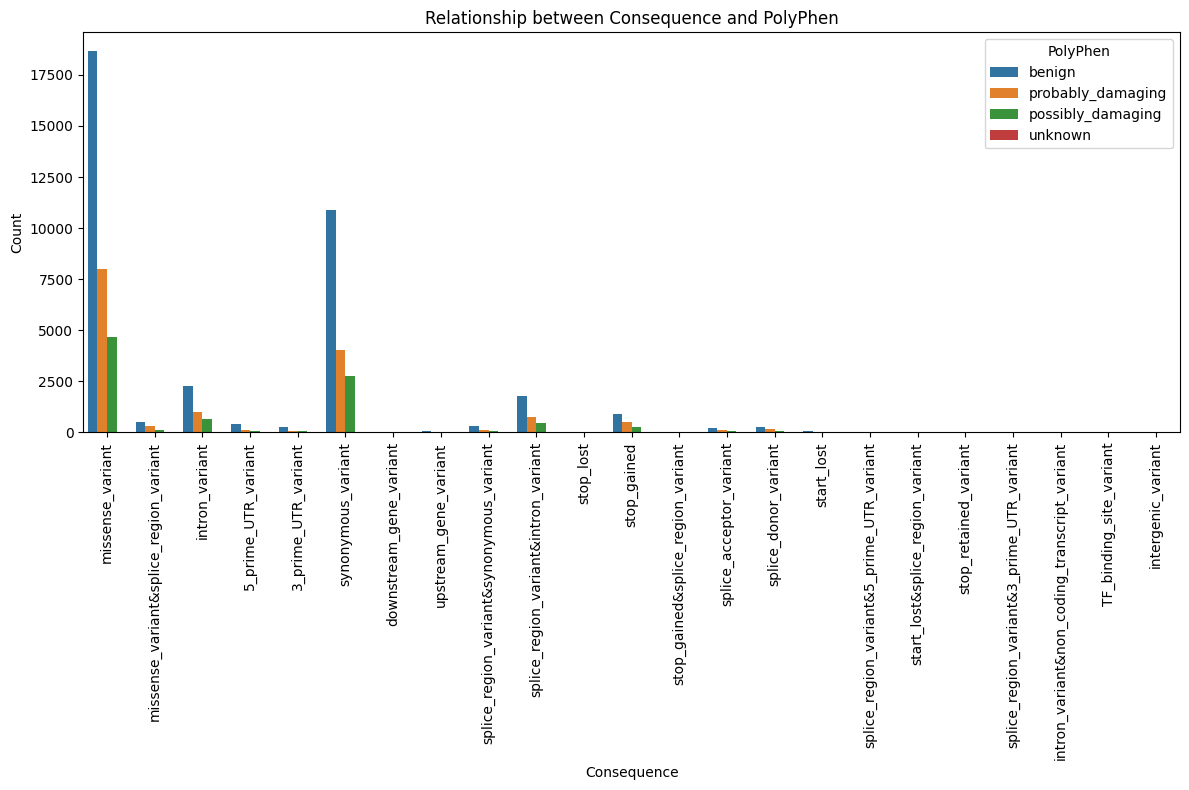

In [52]:
# Create a count plot
plt.figure(figsize=(12, 8))
sns.countplot(x='Consequence', hue='PolyPhen', data=df_original)
plt.xlabel('Consequence')
plt.ylabel('Count')
plt.title('Relationship between Consequence and PolyPhen')
plt.xticks(rotation=90) # Increase rotation value for better readability
plt.legend(title='PolyPhen')
plt.tight_layout() # Ensures labels are not cut off
plt.show()

A count plot was generated above to explore the relationship between the Consequence and
PolyPhen features. By visual inspection, missense variant mutations have the highest total
sample count as well as the highest counts of probably and possibly damaging PoylPhen
results.

In [53]:
# Filter the dataframe
df_filtered = df_original[df_original['Consequence'].str.startswith('missense')]

In [54]:
# encode object variables for model build
df_factorized = df_filtered.copy()

# Iterate over each column in the dataframe
for column in df_factorized.columns:
  # Check if the column's dtype is 'object'
  if df_factorized[column].dtype == 'object':
    df_factorized[column] = pd.factorize(df_factorized[column])[0]

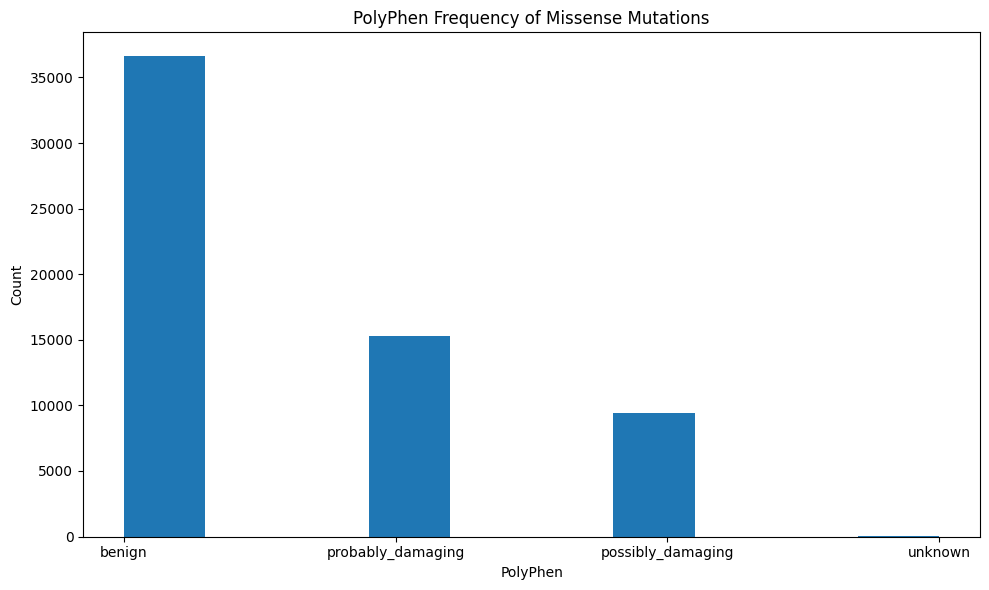

In [55]:
# Generate bar plot for 'PolyPhen'
plt.figure(figsize=(10, 6))
plt.hist(df_original['PolyPhen'])
plt.xlabel('PolyPhen')
plt.ylabel('Count')
plt.title('PolyPhen Frequency of Missense Mutations')
plt.tight_layout()
plt.show()

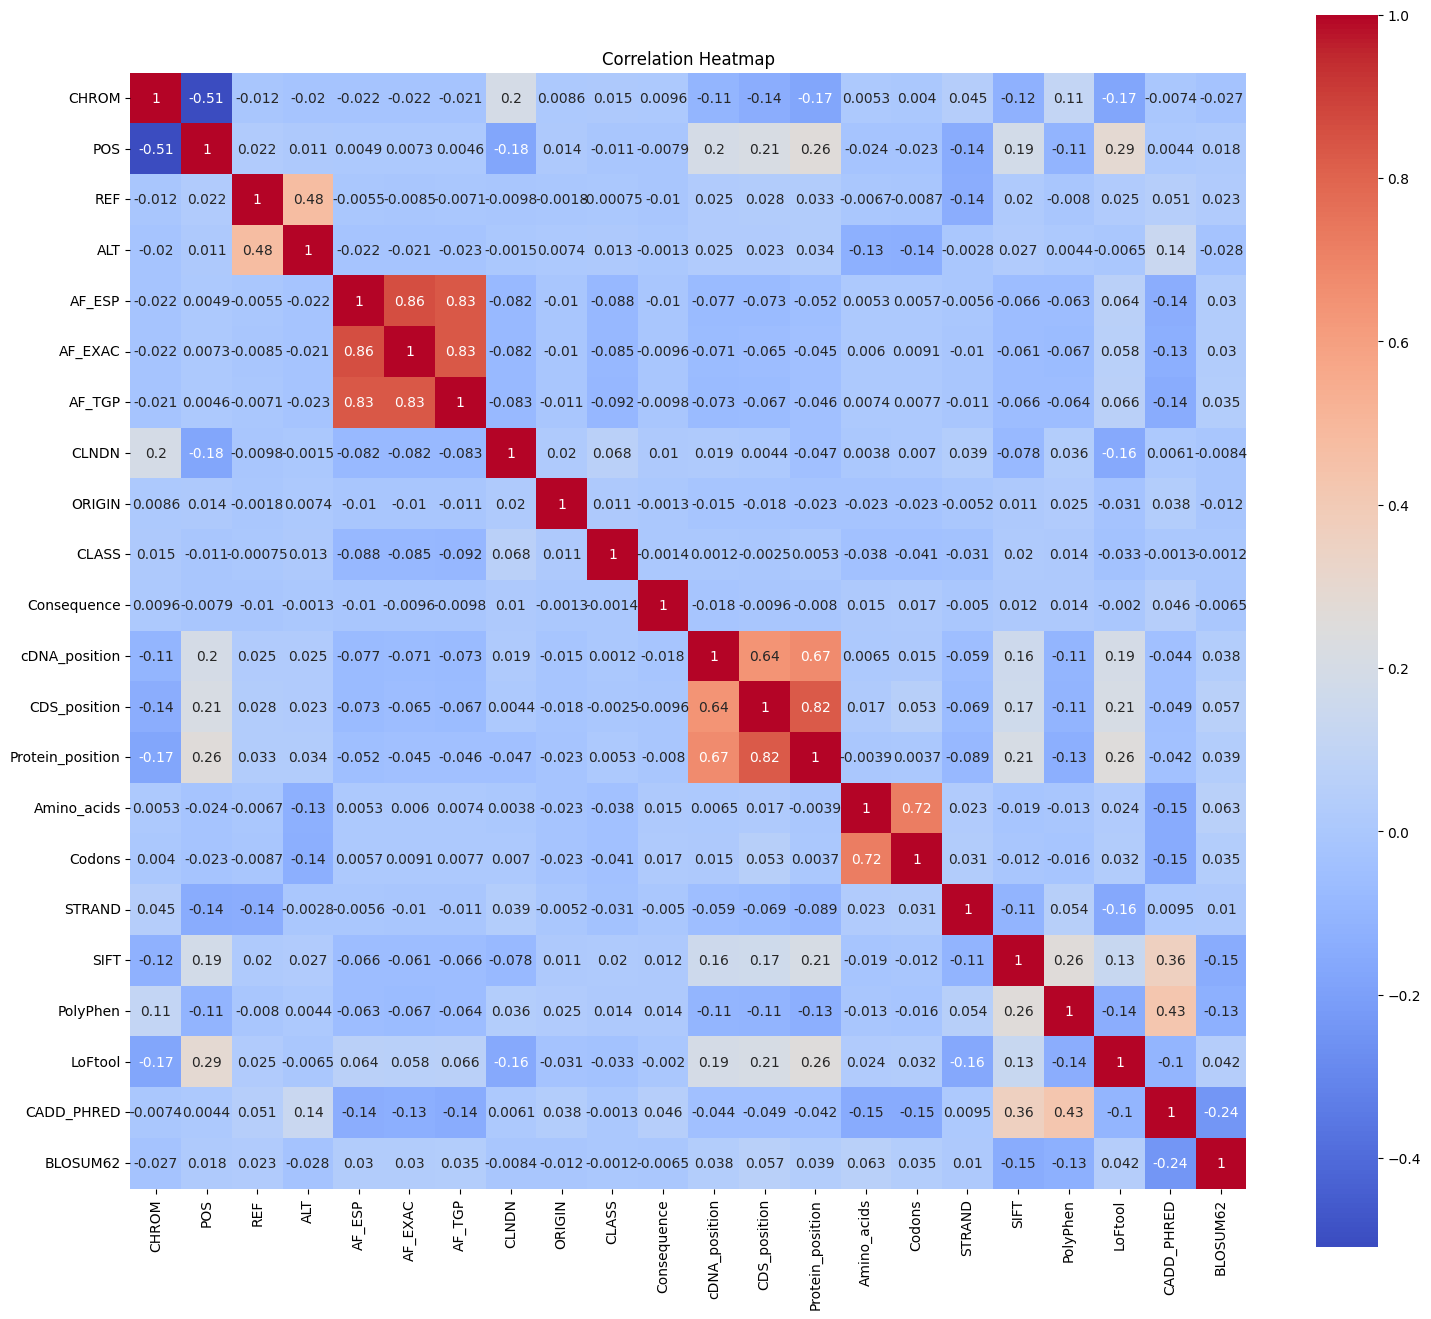

In [56]:
df_factorized.drop(['IMPACT', 'CLNVC'], axis=1, inplace=True)
# Create a heatmap
plt.figure(figsize=(18, 16))
correlation_matrix = df_factorized.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

In [57]:
X = df_factorized.drop('PolyPhen', axis=1)
y = df_factorized['PolyPhen']

# Preprocess the feature matrix to ensure non-negative values
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
k = 10
selector = SelectKBest(score_func=chi2, k=k)
X_new = selector.fit_transform(X, y)

selected_indices = selector.get_support(indices=True)
selected_scores = selector.scores_[selected_indices]
selected_features = df.columns[selected_indices]

for feature, score in zip(selected_features, selected_scores):
  print(f"Feature: {feature}, Score: {score}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_new, y,\
                                  test_size=0.2, random_state=42)

# Create and fit the logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = logreg.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

# Print the selected features
selected_features = df.columns[selected_indices]
print("Selected Features:")
for feature in selected_features:
  print(feature)

Feature: CHROM, Score: 91.83139665532157
Feature: AF_EXAC, Score: 98.37495211901782
Feature: AF_TGP, Score: 101.46518825400895
Feature: IMPACT, Score: 101.91282165167553
Feature: cDNA_position, Score: 118.85309448788595
Feature: CDS_position, Score: 146.86993896382413
Feature: STRAND, Score: 1449.1632290623747
Feature: SIFT, Score: 314.38123161415723
Feature: PolyPhen, Score: 1186.8851100003626
Feature: LoFtool, Score: 214.72414527202199
Accuracy: 0.7215425120024779
Precision: 0.7215425120024779
Recall: 0.7215425120024779
Selected Features:
CHROM
AF_EXAC
AF_TGP
IMPACT
cDNA_position
CDS_position
STRAND
SIFT
PolyPhen
LoFtool


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [58]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,\
                                  test_size=0.2, random_state=42)

# Create and fit the Lasso model
lasso = Lasso(alpha=0.001)
lasso.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = lasso.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)

Mean Squared Error (MSE): 0.41255609143716104
R-squared (R2): 0.24188508566910394


In [59]:
X = df_factorized.drop('PolyPhen', axis=1)
y = df_factorized['PolyPhen']
# Preprocess the feature matrix to ensure non-negative values
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,\
                                  test_size=0.2, random_state=42)
# Create and fit the Gradient Boosting classifier
gb_classifier = xgb.XGBClassifier(n_estimators=100, random_state=42)
gb_classifier.fit(X_train, y_train)
# Make predictions on the testing set
y_pred_xg = gb_classifier.predict(X_test)
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred_xg)
# Calculate the mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred_xg)
# Calculate the R-squared (R2) score
r2 = r2_score(y_test, y_pred_xg)
# Get the selected features
selected_features = df_factorized.drop('PolyPhen', axis=1).columns
# Print the selected features
print("Selected Features:")
for feature in selected_features:
  print(feature)
# Print the evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)
print("Accuracy:", accuracy)

Selected Features:
CHROM
POS
REF
ALT
AF_ESP
AF_EXAC
AF_TGP
CLNDN
ORIGIN
CLASS
Consequence
cDNA_position
CDS_position
Protein_position
Amino_acids
Codons
STRAND
SIFT
LoFtool
CADD_PHRED
BLOSUM62
Mean Squared Error (MSE): 0.43503174849001086
R-squared (R2): 0.20058371798890529
Accuracy: 0.7850394920241598


In [60]:
# Make predictions on the testing set
y_pred_xg = gb_classifier.predict(X_test)
# Create the confusion matrix
confusion = confusion_matrix(y_test, y_pred_xg)
print(confusion)

[[3509  165   89    0]
 [ 288 1350   94    0]
 [ 382  369  210    0]
 [   1    0    0    0]]


## Consequence (resulting mutation)
Per the last target (PolyPhen), Consequence proves to be very important in classifying the
potential damage of genetic mutations. Let's analyze the Consequence column as a whole, as
opposed to strictly missense mutations.

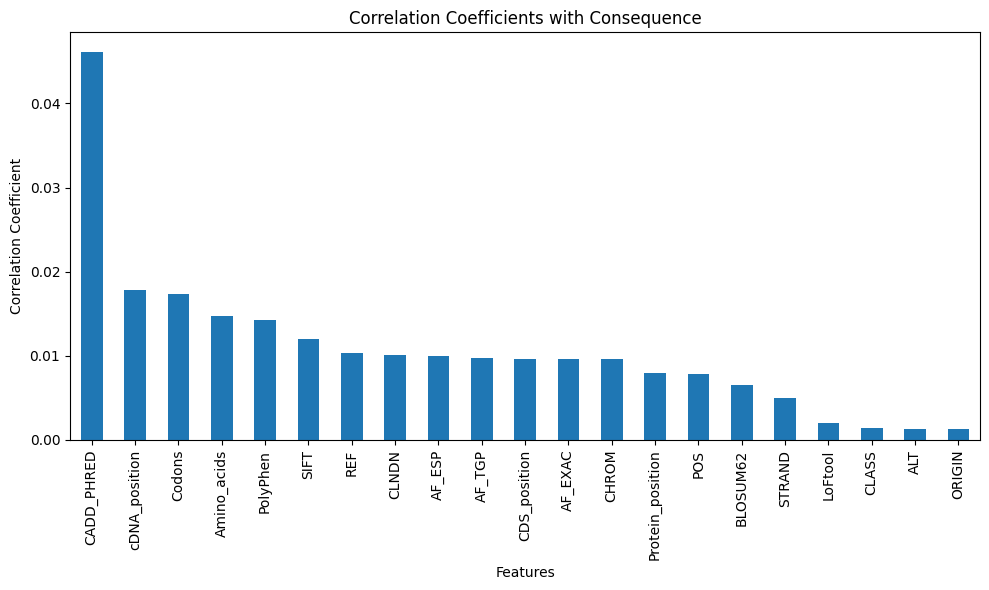

In [61]:
# Calculate the correlation coefficients
correlation_matrix = df_factorized.corr()
correlation_values = correlation_matrix['Consequence'].abs()
# Sort the correlation values in descending order
sorted_correlations = correlation_values.sort_values(ascending=False)
# Plot the sorted correlation coefficients
plt.figure(figsize=(10, 6))
sorted_correlations = sorted_correlations.drop('Consequence')
sorted_correlations.plot(kind='bar')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.title('Correlation Coefficients with Consequence')
plt.tight_layout()
plt.show()

### Model Build

In [62]:
# Separate the feature matrix X and the target variable y
X = df.drop('Consequence', axis=1)
y = df['Consequence']
# Create and fit the Lasso regression model
lasso = Lasso(alpha=0.01) # alpha is the regularization strength
lasso.fit(X, y)
# Get the feature importance scores
lasso_coef = pd.Series(lasso.coef_, index=X.columns)
sorted_coef = lasso_coef.abs().sort_values(ascending=False)
# Print the sorted feature importance scores
print("Sorted Feature Importance Scores:")
print(sorted_coef)

Sorted Feature Importance Scores:
IMPACT              3.644115e+00
ALT                 6.994597e-02
PolyPhen            3.380137e-02
SIFT                3.137545e-02
CADD_PHRED          2.839463e-02
BLOSUM62            1.587991e-02
REF                 8.983891e-03
pca_1               7.474237e-03
Amino_acids         5.286939e-03
CHROM               2.855687e-03
Codons              1.314255e-03
ORIGIN              7.031344e-04
Protein_position    9.526619e-05
CDS_position        5.713235e-05
CLNDN               1.625339e-05
cDNA_position       6.329919e-06
POS                 4.266609e-10
CLASS               0.000000e+00
STRAND              0.000000e+00
AF_TGP              0.000000e+00
LoFtool             0.000000e+00
AF_EXAC             0.000000e+00
AF_ESP              0.000000e+00
AF_avg              0.000000e+00
dtype: float64


In [63]:
# Separate the feature matrix X and the target variable y
X = df.drop('Consequence', axis=1)
y = df['Consequence']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,\
                                test_size=0.2, random_state=42)

# Create and fit the XGBoost classification model
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = xgb_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)
print("Accuracy:", accuracy)

# Print the selected features
print("Selected Features:")
for feature in selected_features:
  print(feature)

Mean Squared Error (MSE): 0.5107285632699682
R-squared (R2): 0.9563463820625628
Accuracy: 0.9353838622827771
Selected Features:
CHROM
POS
REF
ALT
AF_ESP
AF_EXAC
AF_TGP
CLNDN
ORIGIN
CLASS
Consequence
cDNA_position
CDS_position
Protein_position
Amino_acids
Codons
STRAND
SIFT
LoFtool
CADD_PHRED
BLOSUM62


# Final Model Prediction Visualizations

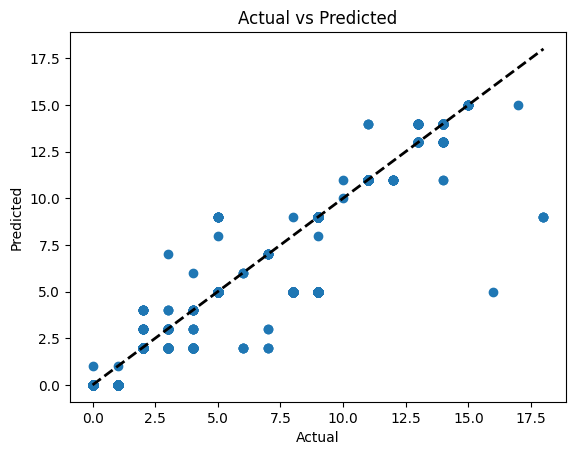

In [64]:
# Create a plot of actual vs predicted values
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

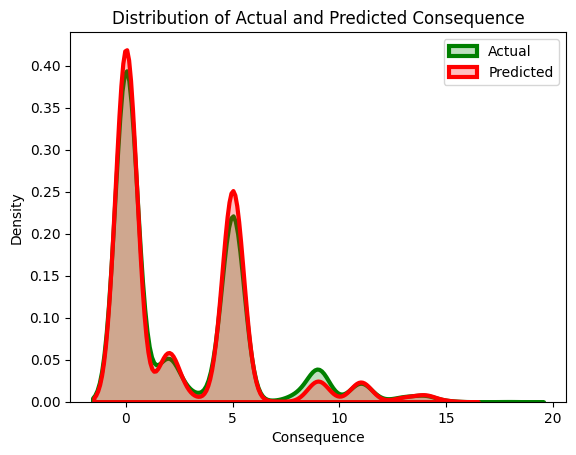

In [65]:
# Create a plot of the distribution of predicted values
sns.kdeplot(y_test, label='Actual', color='g', fill=True, linewidth=3)
sns.kdeplot(y_pred, label='Predicted', color='r', fill=True, linewidth=3)
plt.xlabel('Consequence')
plt.ylabel('Density')
plt.title('Distribution of Actual and Predicted Consequence')
plt.legend()
plt.show()